In [ ]:
# maybe don't show this code? Not necessary for video

# Investigating FIne-Tuning Techniques

In [1]:
from datasets import load_dataset
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)
import torch.nn.functional as F
import torch
from pynvml import (
    nvmlInit,
    nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo,
    nvmlDeviceGetCount,
    nvmlDeviceGetName,
)
import random

# GPU Benchmarking Utilities

In [2]:
def print_gpu_utilization():
    if torch.cuda.is_available():
        nvmlInit()
        deviceCount = nvmlDeviceGetCount()
        for i in range(deviceCount):
            handle = nvmlDeviceGetHandleByIndex(i)
            info = nvmlDeviceGetMemoryInfo(handle)
            print("Device", i, ":", nvmlDeviceGetName(handle))
            print(f"GPU memory occupied: {info.used//1024**2} MB.")
        torch.cuda.empty_cache()


def print_summary(result):
    if torch.cuda.is_available():
        print(f"Time: {result.metrics['train_runtime']:.2f}")
        print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
        print_gpu_utilization()

In [3]:
labels = []
results = []

In [4]:
## set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = 'cuda:1'
print("Using device", DEVICE)

## measure GPU utilization
if torch.cuda.is_available():
    print_gpu_utilization()
    torch.ones((1, 1)).to(DEVICE)
    print_gpu_utilization()

Using device cuda:1
Device 0 : NVIDIA GeForce GTX TITAN X
GPU memory occupied: 54 MB.
Device 1 : NVIDIA TITAN X (Pascal)
GPU memory occupied: 726 MB.
Device 0 : NVIDIA GeForce GTX TITAN X
GPU memory occupied: 155 MB.
Device 1 : NVIDIA TITAN X (Pascal)
GPU memory occupied: 726 MB.


# Load Model and Tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-cased", model_max_length=1024, cache_dir="./cache/"
)
# tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2,
).to(DEVICE)
model.config.use_cache = False
# model.config.pad_token_id = tokenizer.pad_token_id


if torch.cuda.is_available():
    print_gpu_utilization()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Device 0 : NVIDIA GeForce GTX TITAN X
GPU memory occupied: 621 MB.
Device 1 : NVIDIA TITAN X (Pascal)
GPU memory occupied: 868 MB.


# Data Prep

In [6]:
# split = ["train[:1%]", "test[:1%]"]
split = ["train[:500]", "test[:200]"]
raw_train, raw_test = load_dataset(
    "tweet_eval", "offensive",
    split=split
)

print(len(raw_train))
print(raw_train[2]["text"])
print(raw_train[2]["label"])
print(tokenizer.encode(raw_train[2]["text"]))

train = raw_train.map(
    lambda x: tokenizer(x["text"], truncation=True, padding="max_length"),
    batched=True,
)
test = raw_test.map(
    lambda x: tokenizer(x["text"], truncation=True, padding="max_length"),
    batched=True,
)

Found cached dataset tweet_eval (C:/Users/sinan/.cache/huggingface/datasets/tweet_eval/offensive/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\sinan\.cache\huggingface\datasets\tweet_eval\offensive\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-b9d172dac694b8d5.arrow
Loading cached processed dataset at C:\Users\sinan\.cache\huggingface\datasets\tweet_eval\offensive\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-99f0c2dc4a43d411.arrow


500
@user Get him some line help. He is gonna be just fine. As the game went on you could see him progressing more with his reads. He brought what has been missing. The deep ball presence. Now he just needs a little more time
0
[101, 137, 4795, 3949, 1140, 1199, 1413, 1494, 119, 1124, 1110, 6100, 1129, 1198, 2503, 119, 1249, 1103, 1342, 1355, 1113, 1128, 1180, 1267, 1140, 5070, 1158, 1167, 1114, 1117, 9568, 119, 1124, 1814, 1184, 1144, 1151, 3764, 119, 1109, 1996, 3240, 2915, 119, 1986, 1119, 1198, 2993, 170, 1376, 1167, 1159, 102]


# Vanilla Training

In [7]:
default_args = {
    "output_dir": "testing_hyper_params",
    "num_train_epochs": 1,
    "per_device_train_batch_size": 1,
    "evaluation_strategy": "epoch",
     'report_to': "none"
}

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.654013991355896,
 'eval_runtime': 6.798,
 'eval_samples_per_second': 29.421,
 'eval_steps_per_second': 1.912}

In [8]:
result = trainer.train()
labels.append('Vanilla')
results.append(result)
print_summary(result)

C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch,Training Loss,Validation Loss
1,No log,0.527233


Time: 81.83
Samples/second: 6.11
Device 0 : NVIDIA GeForce GTX TITAN X
GPU memory occupied: 1744 MB.
Device 1 : NVIDIA TITAN X (Pascal)
GPU memory occupied: 4191 MB.


# Compiling the model using torch.compile

In [10]:
# compiled_model = torch.compile(model)

# trainer = Trainer(
#     model=compiled_model,
#     train_dataset=train,
#     eval_dataset=test,
#     tokenizer=tokenizer,
#     args=training_args,
# )
# trainer.evaluate()

In [11]:
# result = trainer.train()
# labels.append('Compiled')
# results.append(result)
# print_summary(result)

# Adjust Batch size to 4

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2,
).to(DEVICE)
model.config.use_cache = False

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [13]:
default_args["per_device_train_batch_size"] = 4
print(default_args)
training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
labels.append('Batch Size = 4')
results.append(result)
print_summary(result)

{'output_dir': 'testing_hyper_params', 'num_train_epochs': 1, 'per_device_train_batch_size': 4, 'evaluation_strategy': 'epoch', 'report_to': 'none'}


Epoch,Training Loss,Validation Loss
1,No log,0.597105


Time: 38.15
Samples/second: 13.11
Device 0 : NVIDIA GeForce GTX TITAN X
GPU memory occupied: 3818 MB.
Device 1 : NVIDIA TITAN X (Pascal)
GPU memory occupied: 5751 MB.


# Gradient Accumulation (Adjust Effective Batch size to 4)

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2,
).to(DEVICE)
model.config.use_cache = False

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [15]:
default_args["per_device_train_batch_size"] = 1
default_args["gradient_accumulation_steps"] = 4
print(default_args)

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
labels.append('Gradient Accumulation = 4')
results.append(result)
print_summary(result)

{'output_dir': 'testing_hyper_params', 'num_train_epochs': 1, 'per_device_train_batch_size': 1, 'evaluation_strategy': 'epoch', 'report_to': 'none', 'gradient_accumulation_steps': 4}


Epoch,Training Loss,Validation Loss
0,No log,0.587288


Time: 74.75
Samples/second: 6.69
Device 0 : NVIDIA GeForce GTX TITAN X
GPU memory occupied: 1940 MB.
Device 1 : NVIDIA TITAN X (Pascal)
GPU memory occupied: 4237 MB.


# Mixed Precision

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2,
).to(DEVICE)
model.config.use_cache = False

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [19]:
default_args["fp16"] = True
# default_args["gradient_checkpointing"] = False
default_args["gradient_accumulation_steps"] = 1
default_args["per_device_train_batch_size"] = 1

print(default_args)
training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
labels.append('Mixed Precision')
results.append(result)
print_summary(result)

{'output_dir': 'testing_hyper_params', 'num_train_epochs': 1, 'per_device_train_batch_size': 1, 'evaluation_strategy': 'epoch', 'report_to': 'none', 'gradient_accumulation_steps': 1, 'fp16': True}


Epoch,Training Loss,Validation Loss
1,No log,0.560917


Time: 86.55
Samples/second: 5.78
Device 0 : NVIDIA GeForce GTX TITAN X
GPU memory occupied: 1946 MB.
Device 1 : NVIDIA TITAN X (Pascal)
GPU memory occupied: 4311 MB.


# Dynamic Padding & Uniform Length Batching

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2,
).to(DEVICE)
model.config.use_cache = False

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [21]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

train = raw_train.map(lambda x: tokenizer(x["text"], truncation=True), batched=True)
test = raw_test.map(lambda x: tokenizer(x["text"], truncation=True), batched=True)
default_args["fp16"] = False

print(default_args)
training_args = TrainingArguments(**default_args)

trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=collate_fn,
)
result = trainer.train()
labels.append('Dynamic Padding')
results.append(result)
print_summary(result)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'output_dir': 'testing_hyper_params', 'num_train_epochs': 1, 'per_device_train_batch_size': 1, 'evaluation_strategy': 'epoch', 'report_to': 'none', 'gradient_accumulation_steps': 1, 'fp16': False}


Epoch,Training Loss,Validation Loss
1,No log,0.522907


Time: 62.47
Samples/second: 8.00
Device 0 : NVIDIA GeForce GTX TITAN X
GPU memory occupied: 1258 MB.
Device 1 : NVIDIA TITAN X (Pascal)
GPU memory occupied: 4066 MB.


# Choosing params for my GPUs

In [22]:
default_args["fp16"] = True
default_args["gradient_checkpointing"] = False
default_args["per_device_train_batch_size"] = 4
default_args["gradient_accumulation_steps"] = 4


In [24]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2,
).to(DEVICE)
model.config.use_cache = False

print(default_args)
training_args = TrainingArguments(**default_args)

trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=collate_fn,
)
result = trainer.train()
labels.append('BS=4 + Grad. Accum = 4 + MP + DP')
results.append(result)
print_summary(result)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

{'output_dir': 'testing_hyper_params', 'num_train_epochs': 1, 'per_device_train_batch_size': 4, 'evaluation_strategy': 'epoch', 'report_to': 'none', 'gradient_accumulation_steps': 4, 'fp16': True, 'gradient_checkpointing': False}


Epoch,Training Loss,Validation Loss
0,No log,0.608759


Time: 17.76
Samples/second: 28.15
Device 0 : NVIDIA GeForce GTX TITAN X
GPU memory occupied: 1598 MB.
Device 1 : NVIDIA TITAN X (Pascal)
GPU memory occupied: 4202 MB.


In [25]:
len(labels), len(results)

(6, 6)

In [31]:
results[-1]

TrainOutput(global_step=15, training_loss=0.6465375264485677, metrics={'train_runtime': 17.76, 'train_samples_per_second': 28.153, 'train_steps_per_second': 0.845, 'total_flos': 18561662733600.0, 'train_loss': 0.6465375264485677, 'epoch': 0.95})

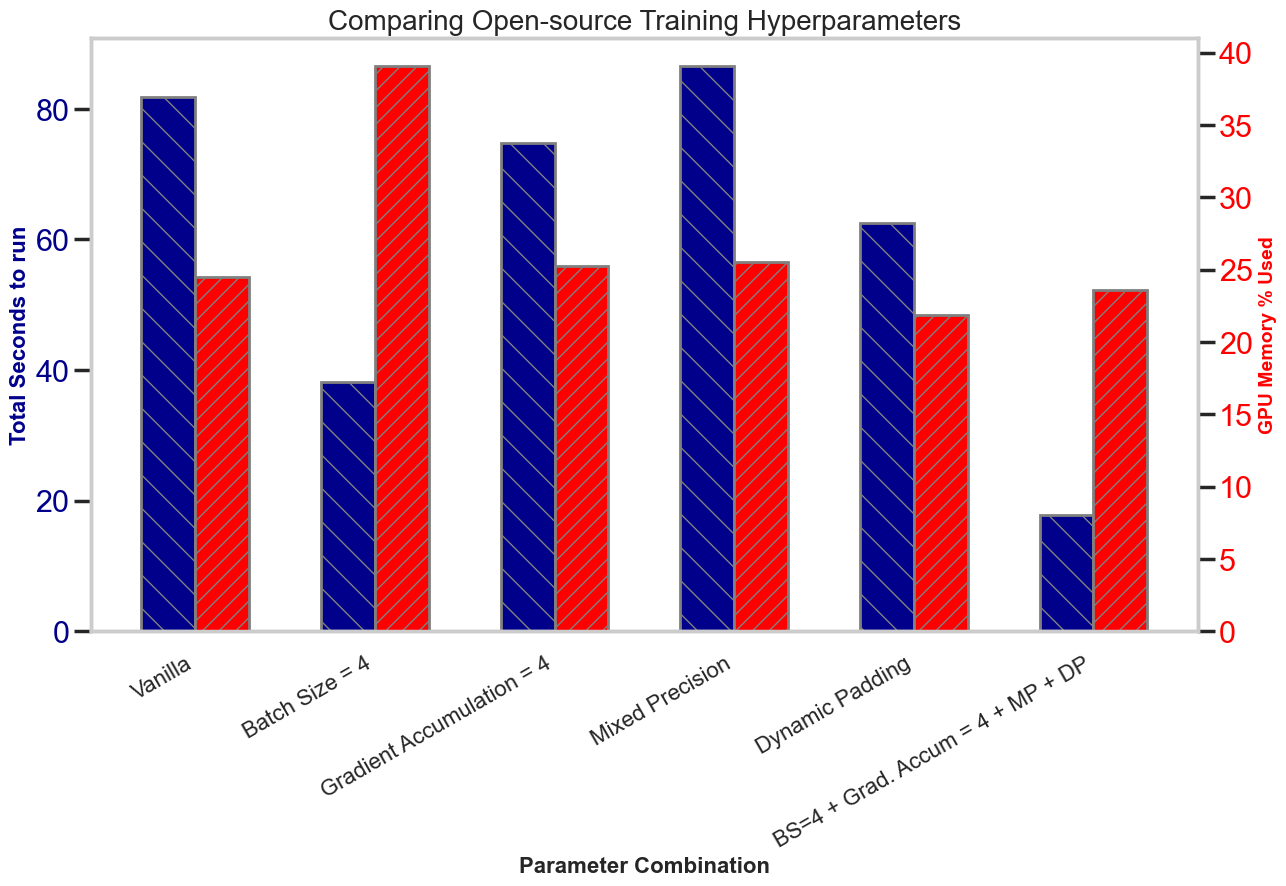

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# this will transform your results into a list of lists (which is easier to plot)

values1 = [r.metrics['train_runtime'] for r in results]
# values2 = [r.metrics['train_samples_per_second'] for r in results]
values2 = [1744+4271, 3818+5787, 1940+4275, 1946+4326, 1258+4117, 1632+ 4159]  # memory
values2 = [(v / (24*1024) * 100) for v in values2]

barWidth = 0.3

# here we generate positions for each group of bars
r1 = np.arange(len(values1))
r2 = [x + barWidth for x in r1]

# create figure and axis objects
fig, ax1 = plt.subplots(figsize=(14, 10))  # Increase the figure size here

color = 'darkblue'
ax1.set_xlabel('Parameter Combination', fontweight='bold', fontsize=16)
ax1.set_ylabel('Total Seconds to run', color=color, fontweight='bold', fontsize=16)
ax1.bar(r1, values1, color=color, width=barWidth, edgecolor='grey', label='Key1', hatch='\\')  # Adding hatch pattern
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([r + barWidth/2 for r in range(len(values1))])
ax1.set_xticklabels(labels, rotation=30, ha='right', fontsize=16)  # Rotate labels less and align right

# instantiate a second axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('GPU Memory % Used', color=color, fontweight='bold', fontsize=14)  # we already handled the x-label with ax1
ax2.bar(r2, values2, color=color, width=barWidth, edgecolor='grey', label='Key2', hatch='//')  # Adding hatch pattern
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False) 
ax1.grid(False) 

plt.title('Comparing Open-source Training Hyperparameters', fontsize=20)
fig.tight_layout(pad=2.0)  # Increase padding

# Save the plot as a PNG
fig.savefig('Training_Comparison.png', dpi=1000, bbox_inches='tight')

plt.show()
